# this is where I got it from

https://bpostance.github.io/posts/clustering-mixed-data/

In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
raw = pd.read_csv('oscars.csv')
raw.head()

,title,runtime,imdb_score,imdb_votes,user_review_count,critic_review_count,critic_overall_score,critic_positive_score,critic_mixed_score,critic_negative_score,user_overall_score,user_positive_score,user_mixed_score,user_negative_score,year_film,year_ceremony,ceremony,category,name,winner
0,The Jazz Singer,88,6.4,9888,113.0,66,66,5,2,0,7.0,3,1,0,1927,1928,1,WRITING (Adaptation),Alfred Cohn,False
1,The Jazz Singer,88,6.4,9888,113.0,66,66,5,2,0,7.0,3,1,0,1952,1953,25,MUSIC (Scoring of a Musical Picture),"Ray Heindorf, Max Steiner",False
2,The Patriot,165,7.2,269439,1200.0,172,63,23,11,1,6.7,113,35,23,1928,1929,2,ACTOR,Lewis Stone,False
3,The Patriot,165,7.2,269439,1200.0,172,63,23,11,1,6.7,113,35,23,1928,1929,2,ART DIRECTION,Hans Dreier,False
4,The Patriot,165,7.2,269439,1200.0,172,63,23,11,1,6.7,113,35,23,1928,1929,2,DIRECTING,Ernst Lubitsch,False


In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
titles = list(raw['title'])
le.fit(titles)
encoded_titles = le.transform(titles)
raw['title'] = encoded_titles

In [4]:
# example of a normalization
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
columns = ['title','runtime', 'imdb_score', 'imdb_votes', 'user_review_count', 'critic_review_count','critic_overall_score','critic_positive_score','critic_mixed_score','critic_negative_score','user_overall_score','user_positive_score','user_mixed_score','user_negative_score','year_film','year_ceremony','ceremony']

In [5]:
# convert numerical-object to numericals
for col in columns:
    raw[col] = raw[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)


In [6]:
# clean textual classes
for col in raw.select_dtypes(include='object').columns:
        raw[col] = raw[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)

In [7]:
data_types = {f:t for f,t in zip(raw.columns,raw.dtypes)}

In [8]:
# copy df
df = raw.copy()
df = df.drop(labels=['winner'],axis=1)

In [9]:
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler

In [10]:
data_meta = pd.DataFrame(df.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'
print(data_meta)

                     name   num       type
0   critic_negative_score    19  numerical
1      critic_mixed_score    24  numerical
2              imdb_score    45  numerical
3   critic_positive_score    45  numerical
4      user_overall_score    56  numerical
5    critic_overall_score    77  numerical
6                category    86  numerical
7                ceremony    91  numerical
8               year_film    91  numerical
9           year_ceremony    91  numerical
10                runtime   129  numerical
11       user_mixed_score   131  numerical
12    user_negative_score   134  numerical
13    critic_review_count   345  numerical
14    user_positive_score   410  numerical
15      user_review_count   583  numerical
16                  title  1336  numerical
17             imdb_votes  1343  numerical
18                   name  3008  numerical


In [11]:
#data_meta.loc[(data_meta['num']<=15) & (~data_meta['name'].isin(['category','name','winner'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['category','name']),'type']='categorical'

categorical_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
numerical_features = list(data_meta.loc[data_meta['type']=='numerical','name'])
print(numerical_features)

['critic_negative_score', 'critic_mixed_score', 'imdb_score', 'critic_positive_score', 'user_overall_score', 'critic_overall_score', 'ceremony', 'year_film', 'year_ceremony', 'runtime', 'user_mixed_score', 'user_negative_score', 'critic_review_count', 'user_positive_score', 'user_review_count', 'title', 'imdb_votes']


In [12]:
df[numerical_features][:2]

,critic_negative_score,critic_mixed_score,imdb_score,critic_positive_score,user_overall_score,critic_overall_score,ceremony,year_film,year_ceremony,runtime,user_mixed_score,user_negative_score,critic_review_count,user_positive_score,user_review_count,title,imdb_votes
0,0.0,2.0,6.4,5.0,7.0,66.0,1.0,1927.0,1928.0,88.0,1.0,0.0,66.0,3.0,113.0,1045.0,9888.0
1,0.0,2.0,6.4,5.0,7.0,66.0,25.0,1952.0,1953.0,88.0,1.0,0.0,66.0,3.0,113.0,1045.0,9888.0


In [13]:
# Standard Scaled "mean normalisation"
scaler = StandardScaler()
scaler.fit(df[numerical_features])
print("Feature Means:\t",[f"{x:.2}" for x in scaler.mean_])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

Feature Means:	 ['0.6', '3.5', '7.5', '1.6e+01', '6.6', '7.5e+01', '5.4e+01', '2e+03', '2e+03', '1.3e+02', '2.1e+01', '1.9e+01', '1.3e+02', '2.2e+02', '4.9e+02', '6.4e+02', '2e+05']


,critic_negative_score,critic_mixed_score,imdb_score,critic_positive_score,user_overall_score,critic_overall_score,ceremony,year_film,year_ceremony,runtime,user_mixed_score,user_negative_score,critic_review_count,user_positive_score,user_review_count,title,imdb_votes
0,-0.419553,-0.415185,-1.781635,-1.043574,0.127831,-0.693879,-2.380749,-2.423122,-2.423122,-1.463592,-0.521495,-0.40332,-0.602845,-0.42927,-0.504924,1.044601,-0.561136
1,-0.419553,-0.415185,-1.781635,-1.043574,0.127831,-0.693879,-1.294738,-1.292995,-1.292995,-1.463592,-0.521495,-0.40332,-0.602845,-0.42927,-0.504924,1.044601,-0.561136


In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

,critic_negative_score,critic_mixed_score,imdb_score,critic_positive_score,user_overall_score,critic_overall_score,ceremony,year_film,year_ceremony,runtime,user_mixed_score,user_negative_score,critic_review_count,user_positive_score,user_review_count,title,imdb_votes
0,0.0,0.076923,0.45098,0.111111,0.76087,0.595238,0.000000,0.000000,0.000000,0.234694,0.001825,0.0,0.09,0.000516,0.013989,0.782772,0.00381
1,0.0,0.076923,0.45098,0.111111,0.76087,0.595238,0.263736,0.271739,0.271739,0.234694,0.001825,0.0,0.09,0.000516,0.013989,0.782772,0.00381


In [15]:
nominal_features = [c for c in categorical_features]
print("Nominals:\n",nominal_features)

nominal_data = list()
for i,x in df[nominal_features].nunique().iteritems():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))
        
nominal_data = pd.concat(nominal_data,axis=1)

Nominals:
 ['category', 'name']


In [16]:
df

,title,runtime,imdb_score,imdb_votes,user_review_count,critic_review_count,critic_overall_score,critic_positive_score,critic_mixed_score,critic_negative_score,user_overall_score,user_positive_score,user_mixed_score,user_negative_score,year_film,year_ceremony,ceremony,category,name
0,1045.0,88.0,6.4,9888.0,113.0,66.0,66.0,5.0,2.0,0.0,7.0,3.0,1.0,0.0,1927.0,1928.0,1.0,WRITINGADAPTATION,ALFREDCOHN
1,1045.0,88.0,6.4,9888.0,113.0,66.0,66.0,5.0,2.0,0.0,7.0,3.0,1.0,0.0,1952.0,1953.0,25.0,MUSICSCORINGOFAMUSICALPICTURE,RAYHEINDORFMAXSTEINER
2,1112.0,165.0,7.2,269439.0,1200.0,172.0,63.0,23.0,11.0,1.0,6.7,113.0,35.0,23.0,1928.0,1929.0,2.0,ACTOR,LEWISSTONE
3,1112.0,165.0,7.2,269439.0,1200.0,172.0,63.0,23.0,11.0,1.0,6.7,113.0,35.0,23.0,1928.0,1929.0,2.0,ARTDIRECTION,HANSDREIER
4,1112.0,165.0,7.2,269439.0,1200.0,172.0,63.0,23.0,11.0,1.0,6.7,113.0,35.0,23.0,1928.0,1929.0,2.0,DIRECTING,ERNSTLUBITSCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4369,1033.0,115.0,8.3,317582.0,523.0,382.0,77.0,27.0,3.0,0.0,8.4,243.0,14.0,8.0,2013.0,2014.0,86.0,FOREIGNLANGUAGEFILM,DENMARK
4370,338.0,80.0,7.8,20205.0,64.0,107.0,86.0,21.0,1.0,0.0,7.7,74.0,5.0,7.0,2013.0,2014.0,86.0,ANIMATEDFEATUREFILM,BENJAMINRENNERANDDIDIERBRUNNER
4371,178.0,93.0,7.1,400294.0,565.0,503.0,69.0,29.0,8.0,0.0,7.2,593.0,173.0,58.0,2012.0,2013.0,85.0,ANIMATEDFEATUREFILM,MARKANDREWSANDBRENDACHAPMAN
4372,900.0,106.0,6.9,599938.0,700.0,463.0,62.0,21.0,13.0,3.0,7.0,543.0,207.0,71.0,2012.0,2013.0,85.0,MUSICORIGINALSONG,MUSICBYWALTERMURPHYLYRICBYSETHMACFARLANE


In [17]:
# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_data,nominal_data],axis=1)
#print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

# original data
Xy_original = df[numerical_features+nominal_features].copy()

In [18]:
print(Xy_scaled.min().min())

0.0


In [19]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [6]:
Xy_,clusters_ = make_blobs(n_samples=4000, centers=5, cluster_std=0.7)
df_ = pd.DataFrame(Xy_,columns=['X','Y'])
df_['K'] = clusters_
sns.scatterplot(x='X',y='Y',hue='K',data=df_);

NameError: name 'pd' is not defined

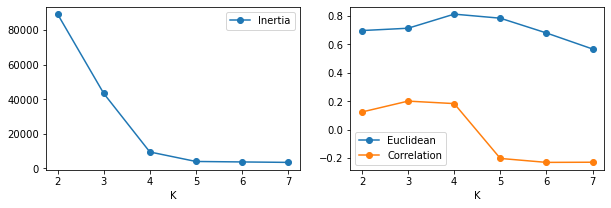

In [21]:
results = dict()
k_cand = [2,3,4,5,6,7] #

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,2,sharex=True,figsize=(10,3))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

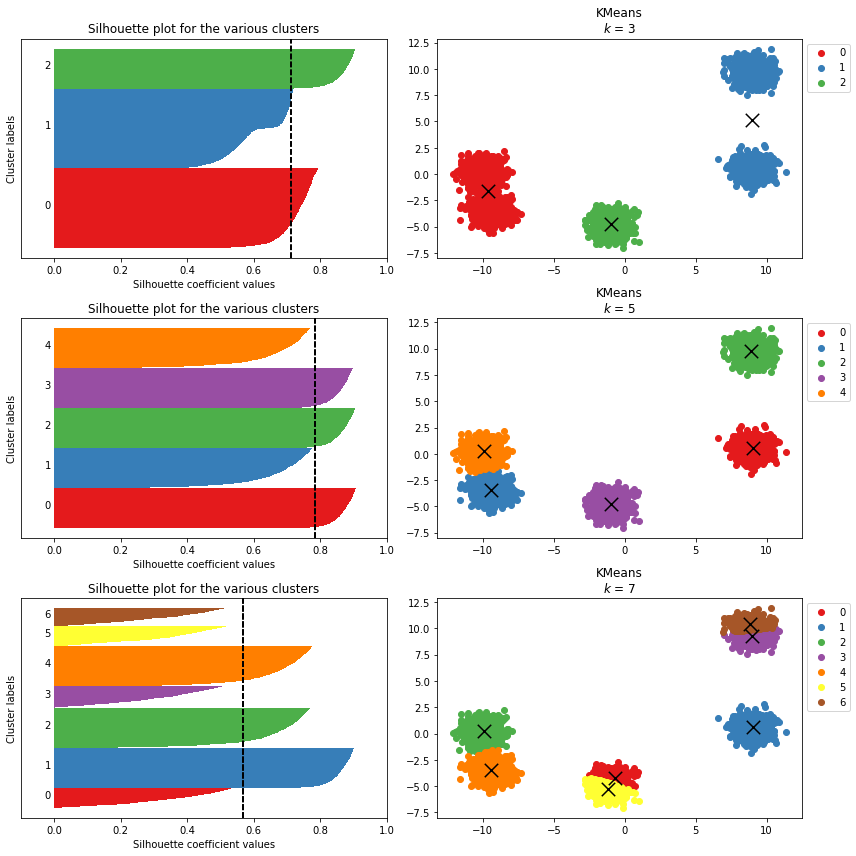

In [22]:
k_cand = [3,5,7]

fig,axs = plt.subplots(len(k_cand),2,figsize=(12,12))

for e,k in enumerate(k_cand):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    
    cdict = {i:cm.Set1(i) for i in np.unique(kmeans.labels_)}
    
    ## silhouette samples
    silhouette_vals = silhouette_samples(Xy_,kmeans.labels_)
    y_lower = 0 
    y_upper = 0
    for i,cluster in enumerate(np.unique(kmeans.labels_)):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        axs[e,0].barh(range(y_lower,y_upper),
                      cluster_silhouette_vals,
                      height=1,
                      color=cdict[cluster])
        axs[e,0].text(-0.03,(y_lower+y_upper)/2,str(i))
        
        y_lower += len(cluster_silhouette_vals) # add for next iteration 
        avg_score = np.mean(silhouette_vals)
        axs[e,0].axvline(avg_score,linestyle ='--',color = 'black')
        
        axs[e,0].set_yticks([])
        axs[e,0].set_xlim([-0.1, 1])
        axs[e,0].set_xlabel('Silhouette coefficient values')
        axs[e,0].set_ylabel('Cluster labels')
        axs[e,0].set_title('Silhouette plot for the various clusters')
        
    ## plot data and cluster centroids
    results = pd.DataFrame(Xy_)
    results['k'] = kmeans.labels_
    for cluster in np.unique(kmeans.labels_): # plot data by cluster
        axs[e,1].scatter(x=results.where(results['k']==cluster)[0],
                         y=results.where(results['k']==cluster)[1],
                         color=cdict[cluster],
                         label=cluster)
    # plot centroids
    axs[e,1].scatter(x=kmeans.cluster_centers_[:,0],
                     y=kmeans.cluster_centers_[:,1],
                     marker='x',color='black',s=180)
    axs[e,1].legend(bbox_to_anchor=(1,1))
    axs[e,1].set_title(f"KMeans\n$k$ = {k}")
    plt.tight_layout()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.506529
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.950760
[t-SNE] KL divergence after 500 iterations: 1.544338


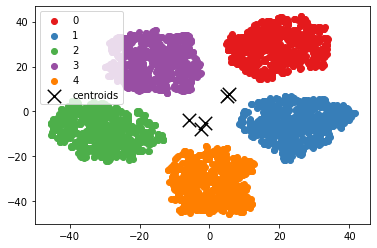

In [23]:
a,b = make_blobs(n_samples=4000,n_features=5, centers=5, cluster_std=0.7)
kmeans = KMeans(n_clusters=5, random_state=0).fit(a)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(a)
tsne = pd.DataFrame(tsne)
tsne['k'] = kmeans.labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1],
                color=cdict[cluster],
                label=cluster)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            marker='x',color='black',s=180,
            label='centroids')
plt.legend();

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 50, 100, 150, 200, 250, 300, 350, 400, 450]
5
5
10
10
15
15
20
20
25
25
30
30
35
35
40
40
45
45
50
50
50
50
100
100
150
150
200
200
250
250
300
300
350
350
400
400
450
450


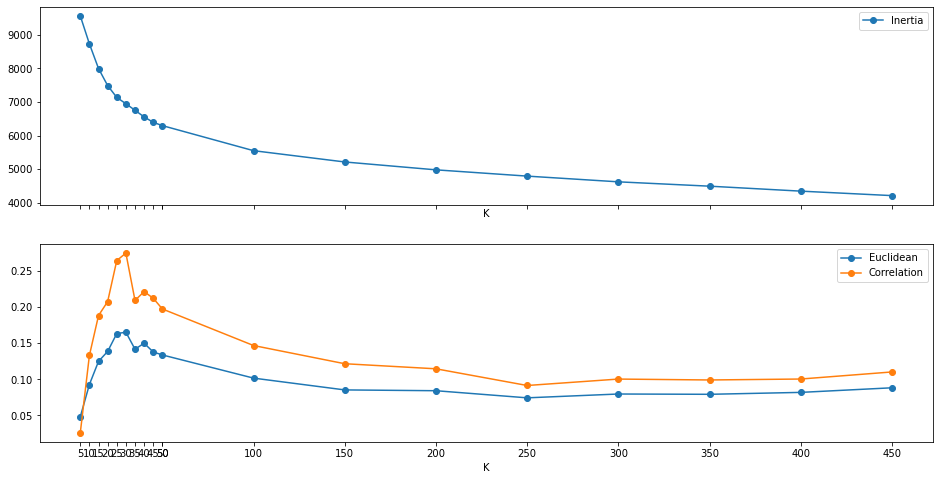

In [28]:
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))
print(k_cand)

for k in k_cand:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_scaled)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_scaled,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_scaled,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}
    print(k)

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4374 samples in 0.010s...
[t-SNE] Computed neighbors for 4374 samples in 0.561s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4374
[t-SNE] Computed conditional probabilities for sample 2000 / 4374
[t-SNE] Computed conditional probabilities for sample 3000 / 4374
[t-SNE] Computed conditional probabilities for sample 4000 / 4374
[t-SNE] Computed conditional probabilities for sample 4374 / 4374
[t-SNE] Mean sigma: 0.402788
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.539066
[t-SNE] KL divergence after 500 iterations: 0.787287


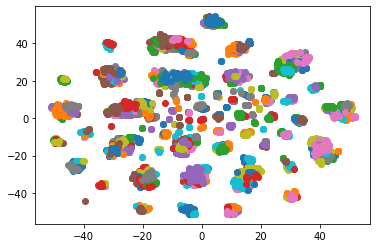

In [29]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy_scaled)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[400]['k'].labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1]
               )

critic_negative_score                  critic_mixed_score                    \
                   mean median       var               mean median        var   
k                                                                               
0              0.170213    0.0  0.231267           2.127660    2.0   2.635523   
1              0.625806    0.0  2.924005           3.593548    3.0  10.359698   

  imdb_score                  critic_positive_score  ... user_positive_score  \
        mean median       var                  mean  ...                 var   
k                                                    ...                       
0   7.331915    7.2  0.250481              8.808511  ...         6402.211841   
1   7.552903    7.5  0.225235             20.683871  ...       148779.160201   

  user_review_count                             title                        \
               mean median            var        mean median            var   
k                                                                             
0        223.617021  156.0   41102.154487  631.680851  586.0  136982.917669   
1        492.942581  258.0  353273.857786  643.141935  649.0  155415.096607   

      imdb_votes                         
            mean   median           var  
k                                        
0   58954.595745  22571.0  7.995558e+09  
1  225227.006452  93754.0  1.112461e+11  

[2 rows x 51 columns]

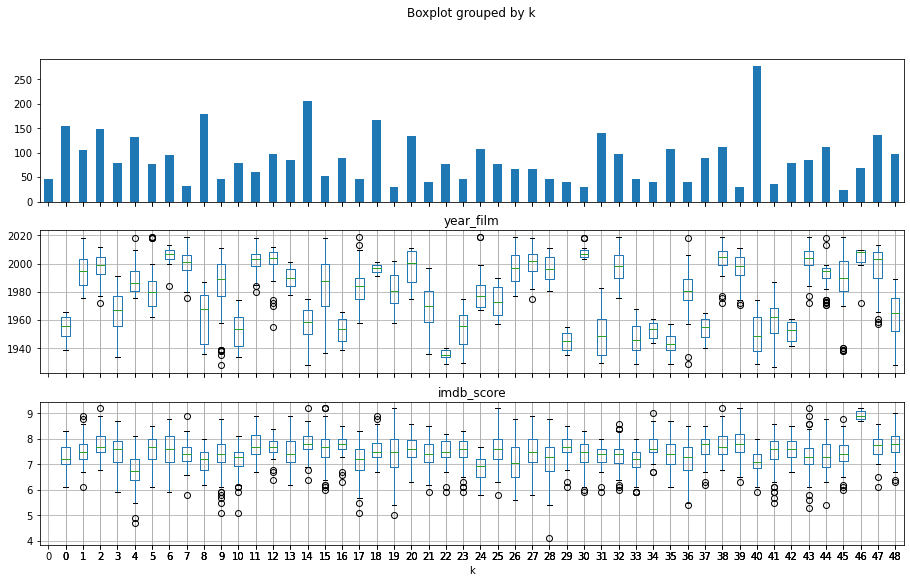

In [32]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=True)
Xy_original['k'] = results[50]['k'].labels_

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='year_film',ax=axs[1])
Xy_original.boxplot(by='k',column='imdb_score',ax=axs[2])

Xy_original.groupby('k').agg(["mean", "median", "var"])[:2]

In [33]:
# drop cluster labels
Xy_original.drop(labels=['k'],axis=1,inplace=True)

In [35]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform

CPU times: user 14 s, sys: 899 µs, total: 14.1 s
Wall time: 14 s


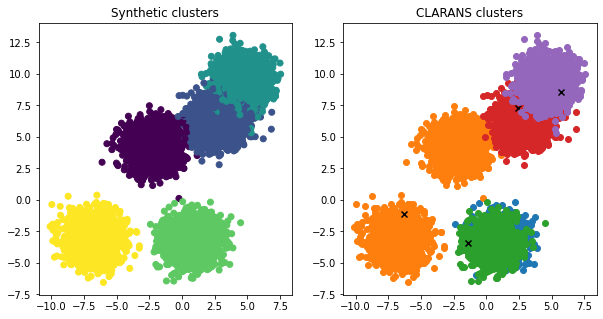

In [2]:
from pyclustering.cluster.clarans import clarans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# synthetic clusters
I,c = make_blobs(10302,n_features=36,centers=5)

# implement clarans
clarans_instance = clarans(I.tolist(), 5, 2, 4);
%time clarans_instance.process()
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(I[:,2],I[:,1],c=c)
axs[0].set_title('Synthetic clusters')
axs[1].set_title('CLARANS clusters')
for c_,m in zip(clusters,medoids):
    axs[1].scatter(I[c_,2],I[c_,1])
    axs[1].scatter(I[m,2],I[m,1],marker='x',c='black',label='medoids')

In [4]:
import gower

In [ ]:
cat = [True if x in categorical_features else False for x in Xy_original.columns]

n = 5
focus = Xy_original.sample(1)
similar = gower.gower_topn(focus,Xy_original,
                           n=n,cat_features=cat)

In [ ]:
print(similar['values'])
Xy_original.iloc[similar['index']]

In [ ]:
# create list of cat_feature indicator
cat = [True if x in categorical_features else False for x in Xy_original.columns]

%time gd = gower.gower_matrix(Xy_original, cat_features=cat)

In [ ]:
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {gd.shape}")
pd.DataFrame(gd[:3,:3])

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [ ]:
# condensed matrix
gdv = squareform(gd,force='tovector')

# output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(gdv,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=5,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

In [ ]:
# find k clusters
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score0 = silhouette_score(gd, cluster_array, metric='precomputed')
    score1 = silhouette_score(Xy_scaled, cluster_array,metric='cityblock')
    results[k] = {'k':cluster_array,'s0':score0,'s1':score1}
    
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Gower')
axs.plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Cityblock')
axs.set_xlim(1,451)
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=False)
Xy_original['k'] = results[5]['k']

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='AGE',ax=axs[1])
Xy_original.boxplot(by='k',column='INCOME',ax=axs[2])